In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Image Classification with Convolutional Neural Network

In this exercise, we will train an image classification network with PyTorch.
We will use CIFAR-10 Dataset which consists of 10 object classes. 

Here are the official API documentation for each component. 

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


## Training a classifier

These steps will be followed:

1. Load CIFAR10 training dataset and split into train and val split.

2. Load the Convolutional Neural Network.

3. Complete the evaluation code.

4. Complete the training code.

5. Define optimizer and criterion.

6. Train the models. 


## 1. Load the dataset 

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy

In [3]:
# Create train/val split (45k/5k)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse   car plane  frog


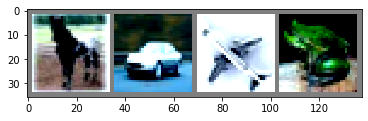

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment but it is highly recommended. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variable `device` will control the data types throughout this assignment. 

In [5]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## 2. Load a Convolutional Neural Network

Load an existing CNN architecture from torchvision, namely ResNet18. There is a nice blogpost explaining the ResNet architectures here: https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

Torchvision provides a pretrained ResNet18 model, however on ImageNet dataset which has 1000 classes. In our case, we need to modify the last layer of the model so that it predicts 10 classes.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [7]:
## Load Resnet18 from torchvision.
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

In [8]:
# Send model to device.
model = model.to(device=device)

## 3. Complete the evaluation loop

Check the accuracy before training the model. You need to complete the evaluation code in "evaluation.py"

In [9]:
from evaluation import check_accuracy

# TODO: complete the check_accuracy function. Check the validation split accuracy.
check_accuracy(valloader, model, device)


Got 538 / 5000 correct (10.76)


## Initiate the Tensorboard writer

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/cifar10_experiments_resnet')

## 4. Complete the training loop

In [11]:

## TODO: Complete the train_model function.

def train_model(model, criterion, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    running_loss = 0.0
    for epoch in range(epochs):
        for i, data in enumerate(trainloader):
            
            ## TODO: Set model to training mode
            model.train()
            
            inputs, labels = data
            inputs = inputs.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            labels = labels.to(device=device, dtype=torch.long)

            ## TODO: Run the model with input data.
            outputs = model(inputs)
            
            ## TODO: Estimate the loss by using the criterion.
            loss = criterion(outputs, labels)

            ## TODO: Zero out all of the gradients for the variables which the optimizer
            ## will update.
            optimizer.zero_grad()

            ## TODO: Backward pass. Compute the gradient of the loss with
            ## respect to each  parameter of the model.
            loss.backward()

            ## TODO: Actually update the parameters of the model using the gradients
            ## computed by the backwards pass.
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] Running loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                
                # Append statistics to tensorboard
                writer.add_scalar('training loss',
                            running_loss / 2000,
                            len(trainloader)/1000 * epoch + (i+1) /1000)
                
                running_loss = 0.0

        # Check accuracy on validation set
        check_accuracy(valloader, model, device)
        print()

## 5. Define the optimizer and the criterion


In [12]:
import torch.optim as optim

## TODO: Define the optimizer the function, adjust learning rate (eg. 0.1, 0.01, 0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
## TODO: Define the loss criterion
criterion = nn.CrossEntropyLoss()

## 6. Train the Model and Evaluate on Full Test Data


In [13]:
## TODO: Train model.
train_model(model, criterion, optimizer, epochs=10)

[1,  2000] Running loss: 2.357
[1,  4000] Running loss: 2.072
[1,  6000] Running loss: 1.943
[1,  8000] Running loss: 1.857
[1, 10000] Running loss: 1.776
Got 2249 / 5000 correct (44.98)

[2,  2000] Running loss: 2.699
[2,  4000] Running loss: 1.582
[2,  6000] Running loss: 1.565
[2,  8000] Running loss: 1.501
[2, 10000] Running loss: 1.445
Got 2888 / 5000 correct (57.76)

[3,  2000] Running loss: 2.262
[3,  4000] Running loss: 1.295
[3,  6000] Running loss: 1.329
[3,  8000] Running loss: 1.267
[3, 10000] Running loss: 1.262
Got 3120 / 5000 correct (62.40)

[4,  2000] Running loss: 1.957
[4,  4000] Running loss: 1.175
[4,  6000] Running loss: 1.144
[4,  8000] Running loss: 1.128
[4, 10000] Running loss: 1.098
Got 3194 / 5000 correct (63.88)

[5,  2000] Running loss: 1.726
[5,  4000] Running loss: 1.053
[5,  6000] Running loss: 1.016
[5,  8000] Running loss: 1.042
[5, 10000] Running loss: 0.992
Got 3307 / 5000 correct (66.14)

[6,  2000] Running loss: 1.548
[6,  4000] Running loss: 0.95

In [14]:
## TODO: Check validation accuracy.
check_accuracy(valloader, model, device)

Got 3639 / 5000 correct (72.78)


### Save this model as a checkpoint.

In [15]:
## TODO: Here, you need to use a specific pytorch function to save the model.
file_name = "resnet_cifar.pth"
torch.save(model.state_dict(), file_name)

## 7. Now, train the CNN you have defined in previous exercise. 

Successfully training this network should result in approximately **70% validation accuracy.**


In [16]:
from graph import Net

## Todo: Initiate your own network
net = Net()
writer = SummaryWriter('runs/cifar10_experiments_mygraph')

In [17]:
## TODO: Define the optimizer the function, adjust learning rate
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## TODO: Define the loss criterion
criterion = nn.CrossEntropyLoss()

In [18]:
## TODO: Train the model
train_model(net, criterion, optimizer, epochs=10)

[1,  2000] Running loss: 2.060
[1,  4000] Running loss: 1.680
[1,  6000] Running loss: 1.514
[1,  8000] Running loss: 1.419
[1, 10000] Running loss: 1.331
Got 2780 / 5000 correct (55.60)

[2,  2000] Running loss: 1.969
[2,  4000] Running loss: 1.102
[2,  6000] Running loss: 1.065
[2,  8000] Running loss: 1.038
[2, 10000] Running loss: 0.989
Got 3319 / 5000 correct (66.38)

[3,  2000] Running loss: 1.512
[3,  4000] Running loss: 0.896
[3,  6000] Running loss: 0.883
[3,  8000] Running loss: 0.876
[3, 10000] Running loss: 0.844
Got 3501 / 5000 correct (70.02)

[4,  2000] Running loss: 1.271
[4,  4000] Running loss: 0.771
[4,  6000] Running loss: 0.762
[4,  8000] Running loss: 0.748
[4, 10000] Running loss: 0.757
Got 3531 / 5000 correct (70.62)

[5,  2000] Running loss: 1.126
[5,  4000] Running loss: 0.662
[5,  6000] Running loss: 0.677
[5,  8000] Running loss: 0.675
[5, 10000] Running loss: 0.692
Got 3638 / 5000 correct (72.76)

[6,  2000] Running loss: 0.992
[6,  4000] Running loss: 0.59

In [19]:
# TODO: Report the accuracy on validation split.
check_accuracy(valloader, net, device)

Got 3484 / 5000 correct (69.68)


In [20]:
## TODO: Save the model checkpoint.
file_name = "mygraph.pth"
torch.save(net.state_dict(), file_name)

Additionally, you can check the number of parameters in your model with this function:

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
count_parameters(net)

922378

In [23]:
count_parameters(model)

11181642

## Bonus Question:

Experiment with any architectures, optimizers and hyperparameters. 
Write out your observations. Which model performs better and why? You can even try to get the best accuracy for CIFAR-10. 
    

### Some possibilities to try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Alternative optimizers**: you can try Adam, Adagrad, RMSprop, etc.
- **Alternative activation functions**: such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.
- **Model ensembles**
- **Data augmentation**
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).



## Answer:

[FILL THIS IN]